<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/speaker_indep_bigru_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>IMPORTANT</b>: In order to access our files stored in Google Drive, you need to visit the following link: https://drive.google.com/drive/folders/1Qfr8TNZSlrhpKgYx0LrTxve9ljIFwqRq?usp=sharing

Then, click on the "DeepLearning" folder just beneath the search bar, then select "Add shortcut to Drive", then select "My Drive" and create a shortcut. After that, you should be able to see our folder and the files within when you are mounting your drive. The paths to the files in the code should work as inteded, but we can't cross out the possibility that you might need to change some filepaths (it worked for us and we also tested it with our other 3rd party accounts). If you have any questions or something does not work, please contact us.

## Obtaining the data

In [1]:
%%capture
!pip install fastdtw
!pip install pysptk      
!pip install pyworld

In [2]:
import shutil
from google.colab import drive
import zipfile


drive.mount('/content/drive')
# Data extraction

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DeepLearning/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

# Original electrode name extraction
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DeepLearning/subject_channels.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

# Copying the modules into the base directory
shutil.copyfile("/content/drive/MyDrive/DeepLearning/MelFilterBank.py", "/content/MelFilterBank.py")
shutil.copyfile("/content/drive/MyDrive/DeepLearning/reconstructWave.py", "/content/reconstructWave.py")


Mounted at /content/drive


'/content/reconstructWave.py'

In [3]:
# In case the Google Drive method doesn't work, you can try getting the files with wget
# And in the case this throws a "429 ERROR", you can download our files from Google Drive, then upload them here (but then you might need to change some filepaths)
"""
#features
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#original electrode names
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hBr7KNrNNl9udDB8OQ0nKt2LD0WfxJ7K' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hBr7KNrNNl9udDB8OQ0nKt2LD0WfxJ7K" -O subject_channels.zip && rm -rf /tmp/cookies.txt
#reconstruction module
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


# Data extraction
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

# Electrode name extraction
zip_ref = zipfile.ZipFile("/content/subject_channels.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
"""


<h3>Preparations and needed functions</h3>

Our plan is to transform every feature vector into a larger dimensional feature vector, which contains all the different electrode names across all the subjects. In the original features, every feature vector consisted of 9 smaller feature vectors which corresponded to the transformed iEEG signals across 9 consecutive timesteps, so every feature vector had some sort of sequentiality within itself. So in order to use BiGRU and Convolutional models effectively, we need to be specific about the ordering of our features.


In [3]:
import pandas as pd
import numpy as np


# Getting the original electrode names
original_electrodes = set()

for subject in ['01','02','03','04','05','06','07','08','09','10']:
  table = pd.read_csv(f'/content/subject_channels/sub-{subject}_task-wordProduction_channels.tsv', sep='\t')
  elecs = set(table['name'])
  original_electrodes = original_electrodes.union(elecs)


# Now indexing them from -4 to 4 in order, so all features vectors will consist of 9 smaller feature vectors which will correspond to the
# 9 consecutive timesteps in the larger dimensional vectors (every step will have 540 channels)
all_electrodes = []
for i in range(9):
  for elec in original_electrodes:
    all_electrodes.append(elec + "T" + str(i-4))


print('Number of different features:', len(all_electrodes))

#we will use this list's indexes to correspond to the feature matrices
all_electrodes = list(all_electrodes) 

Number of different features: 4860


In [4]:
# Function for making every feature vector into a 4860 dimensional vector

def dim_adjust(data, feature_names):
  #create a new matrix with zeros, insert the values into the columns
  #which correspond to the subject's feature names, then concatenate them

  new_matrix = np.zeros((data.shape[0],len(all_electrodes)))
  for column in range(data.shape[1]):
    insert_index = all_electrodes.index(feature_names[column])
    new_matrix[:,insert_index] = data[:,column]
    
  return new_matrix


## Making the iterated test, validation and test sets

In [5]:
import os

feat_path = "/content/features"

# Function to generate the train, val and test features and mel spectrograms

def generate_features_and_spec():
  #Base arrays
  train_feat = np.empty((0, len(all_electrodes)))
  val_feat = np.empty((0, len(all_electrodes)))
  test_feat = np.empty((0, len(all_electrodes)))

  train_spec = np.empty((0, 23))
  val_spec = np.empty((0, 23))
  test_spec = np.empty((0, 23))
  

  for index, subject in enumerate(['01','02','03','04','05','06','07','08','09','10']):
    #loading the features, feature names and mel spectrogram of the subject
    data = np.load(os.path.join(feat_path,f'sub-{subject}_feat.npy'))
    feature_names = np.load(os.path.join(feat_path,f'sub-{subject}_feat_names.npy'))
    spectrogram = np.load(os.path.join(feat_path,f'sub-{subject}_spec.npy'))

    #splittig the features and the labels into 5 parts
    feat_splits = np.array_split(data, 5)
    spec_splits = np.array_split(spectrogram, 5)

    #making the train, val or test arrays for the subject using a 60-20-20 ratio
    #because of the "index" changing, the splitting position will iterate with each subject as well
    subject_train_feat = np.vstack((feat_splits[index % 5],feat_splits[(index+1) % 5],feat_splits[(index+2) % 5]))
    subject_train_spec = np.vstack((spec_splits[index % 5],spec_splits[(index+1) % 5],spec_splits[(index+2) % 5]))

    subject_val_feat = feat_splits[(index+3) % 5]
    subject_val_spec = spec_splits[(index+3) % 5]

    subject_test_feat = feat_splits[(index+4) % 5]
    subject_test_spec = spec_splits[(index+4) % 5]

    #concatenating the dimensionality-adjusted features with the pre-existing feature set
    train_feat = np.concatenate((train_feat, dim_adjust(subject_train_feat, feature_names)))
    val_feat = np.concatenate((val_feat, dim_adjust(subject_val_feat, feature_names)))
    test_feat = np.concatenate((test_feat, dim_adjust(subject_test_feat, feature_names)))

    #concatenating the appropriate arrays with the pre-existing train, val or test labels
    train_spec = np.concatenate((train_spec, subject_train_spec))
    val_spec = np.concatenate((val_spec, subject_val_spec))
    test_spec = np.concatenate((test_spec, subject_test_spec))

  return train_feat, train_spec, val_feat, val_spec, test_feat, test_spec

# Generating the data
train_feat, train_spec, val_feat, val_spec, test_feat, test_spec = generate_features_and_spec()

In [6]:
from sklearn.preprocessing import StandardScaler
# Scaling the data 

scaler = StandardScaler()
scaler.fit(train_feat)
train_feat = scaler.transform(train_feat)
val_feat = scaler.transform(val_feat)
test_feat = scaler.transform(test_feat)

In [7]:
# Reshaping the data for the sequential models

train_feat = np.reshape(train_feat, (train_feat.shape[0], 9, int(train_feat.shape[1]/9)))
val_feat = np.reshape(val_feat, (val_feat.shape[0], 9, int(val_feat.shape[1]/9)))
test_feat = np.reshape(test_feat, (test_feat.shape[0], 9, int(test_feat.shape[1]/9)))

# Fine tuning the models

<h3>Defining the data generators</h3>

In [8]:
from tensorflow.keras.utils import Sequence, set_random_seed

set_random_seed(1234)
np.random.seed(42)

class DataGenerator(Sequence):
    # Initialization
    def __init__(self, data, spec, batch_size=32, dim=(9, 540), shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.shuffle = shuffle
        self.spec = spec
        self.on_epoch_end()

    def __len__(self):
        # Shows the number of batches per epoch
        return int(np.floor(self.data.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1]))
        y_batch = np.empty((self.batch_size, 23))
        for index1, elem in enumerate(indexes):
          X_batch[index1] = self.data[elem]
          y_batch[index1] = self.spec[elem]

        return X_batch, y_batch

    def on_epoch_end(self):
        # Updating the index after each epoch
        self.indexes = np.arange(self.data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


# Creating the generators
train_gen = DataGenerator(train_feat, train_spec, 256)
val_gen = DataGenerator(val_feat, val_spec, 256)

<h3>Tuning the BiGRU model</h3>

In [9]:
%%capture
!pip install keras-tuner

In [10]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, GRU, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt


def create_bigru_optimal(hp):

  model = tf.keras.Sequential()
  model.add(Input(shape=(9, 540)))

  # Recurrent layer 1
  hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=64)
  hp_dropout_1 = hp.Float('dropout_1', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Bidirectional(GRU(units=hp_units_1, return_sequences=True, dropout=hp_dropout_1)))

  # Recurrent layer 2
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
  hp_dropout_2 = hp.Float('dropout_2', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Bidirectional(GRU(units=hp_units_2, return_sequences=True, dropout=hp_dropout_2)))

  # Final layers
  model.add(Flatten())

  hp_dense_units = hp.Int('units_dense', min_value=128, max_value=512, step=64)
  hp_activation = hp.Choice('activation', values=['relu', 'swish'])
  model.add(Dense(hp_dense_units, activation = hp_activation, kernel_initializer='HeNormal'))

  hp_dropout_4 = hp.Float('dropout_4', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Dropout(rate=hp_dropout_4))
  model.add(Dense(23, activation = 'linear'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model


In [11]:
# Setting up the tuner for the BiGRU model
tuner_bigru = kt.Hyperband(create_bigru_optimal,
                     objective='val_loss',
                     max_epochs=10,
                     factor = 3,
                     seed = 42,
                     directory='/content/bigru_opt',
                     project_name='bigru_opt1')

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Note: takes about 30 minutes to optimize
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner_bigru.search(train_gen, epochs=50, validation_data=val_gen, verbose=0, shuffle=True, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bigru=tuner_bigru.get_best_hyperparameters(num_trials=1)[0]

In [13]:
# The optimal parameters

for i in range(1,3):
  print(f'Units on the {i}. GRU layer:', best_hps_bigru.get(f'units_{i}'))
  print(f'Dropout on the {i}. GRU layer:', best_hps_bigru.get(f'dropout_{i}'))
  print("")

print('Units on the dense layer:', best_hps_bigru.get('units_dense'))
print('Dropout before dense layer:', best_hps_bigru.get('dropout_4'))
print('Activation on the dense layer:', best_hps_bigru.get('activation'))

print('Learning rate:', best_hps_bigru.get('learning_rate'))

Units on the 1. GRU layer: 448
Dropout on the 1. GRU layer: 0.0

Units on the 2. GRU layer: 64
Dropout on the 2. GRU layer: 0.2

Units on the dense layer: 128
Dropout before dense layer: 0.1
Activation on the dense layer: relu
Learning rate: 0.0001


<h3>Tuning the Convolutional model</h3>

In [14]:
def create_conv_optimal(hp):
  model = tf.keras.Sequential()

  # 1st conv
  hp_filter_1 = hp.Int('filter_1', min_value=16, max_value=64, step=8)
  hp_kernel_1 = hp.Choice('kernel_1', values=[2,3,4])
  hp_activation_1 = hp.Choice('activation_1', values=['relu', 'swish'])
  model.add(Conv1D(filters=hp_filter_1, kernel_size=hp_kernel_1, activation=hp_activation_1, kernel_initializer='HeNormal', input_shape=(9, 540)))

  hp_dropout_1 = hp.Float('dropout', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Dropout(rate=hp_dropout_1))

  # 2nd conv
  hp_filter_2 = hp.Int('filter_2', min_value=32, max_value=128, step=16)
  hp_kernel_2 = hp.Choice('kernel_2', values=[2,3,4])
  hp_activation_2 = hp.Choice('activation_2', values=['relu', 'swish'])
  model.add(Conv1D(filters=hp_filter_2, kernel_size=hp_kernel_2, activation=hp_activation_2, kernel_initializer='HeNormal'))

  # Last layers
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(units=23, activation='linear'))

  hp_learning_rate = hp.Choice('learning_rate_2', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model



In [15]:
# Setting up the tuner for the convolutional model
tuner_conv = kt.Hyperband(create_conv_optimal,
                     objective='val_loss',
                     max_epochs = 10,
                     factor = 3,
                     seed = 42,
                     directory='/content/conv_opt',
                     project_name='conv_opt1')

In [16]:
# Note: takes about 10-15 minutes to optimize
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner_conv.search(train_gen, epochs=50, validation_data=val_gen, verbose=0, shuffle=True, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_conv=tuner_conv.get_best_hyperparameters(num_trials=1)[0]

In [17]:
# The optimal parameters

for i in range(1,3):
  print(f'Number of filters on the {i}. layer:', best_hps_conv.get(f'filter_{i}'))
  print(f'Kernel size on the {i}. layer:', best_hps_conv.get(f'kernel_{i}'))
  print(f'Activation on the {i}. layer:', best_hps_conv.get(f'activation_{i}'))
  print("")


print('Dropout between the layers:', best_hps_conv.get('dropout'))

print('Learning rate:', best_hps_conv.get('learning_rate_2'))

Number of filters on the 1. layer: 24
Kernel size on the 1. layer: 4
Activation on the 1. layer: swish

Number of filters on the 2. layer: 112
Kernel size on the 2. layer: 4
Activation on the 2. layer: swish

Dropout between the layers: 0.0
Learning rate: 0.001


# Training the tuned models

<h3>BiGRU</h3>

In [18]:
# Fitting and retraining the model with the best params
model_bigru = tuner_bigru.hypermodel.build(best_hps_bigru)

early_stopping=EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

history_bigru = model_bigru.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=[checkpointer, early_stopping])

Epoch 1/100
698/699 [============================>.] - ETA: 0s - loss: 3.9081 - mse: 3.9081
Epoch 1: val_loss improved from inf to 2.11589, saving model to weights1.hdf5
699/699 [==============================] - 23s 26ms/step - loss: 3.9057 - mse: 3.9057 - val_loss: 2.1159 - val_mse: 2.1159
Epoch 2/100
699/699 [==============================] - ETA: 0s - loss: 2.0938 - mse: 2.0938
Epoch 2: val_loss improved from 2.11589 to 2.02171, saving model to weights1.hdf5
699/699 [==============================] - 17s 24ms/step - loss: 2.0938 - mse: 2.0938 - val_loss: 2.0217 - val_mse: 2.0217
Epoch 3/100
697/699 [============================>.] - ETA: 0s - loss: 1.8012 - mse: 1.8012
Epoch 3: val_loss did not improve from 2.02171
699/699 [==============================] - 16s 23ms/step - loss: 1.8014 - mse: 1.8014 - val_loss: 2.1868 - val_mse: 2.1868
Epoch 4/100
697/699 [============================>.] - ETA: 0s - loss: 1.6109 - mse: 1.6109
Epoch 4: val_loss did not improve from 2.02171
699/699 [

In [19]:
# Prediction on the test set
model_bigru.load_weights('weights1.hdf5')
pred_bigru = model_bigru.predict(test_feat)

1865/1865 [==============================] - 8s 4ms/step


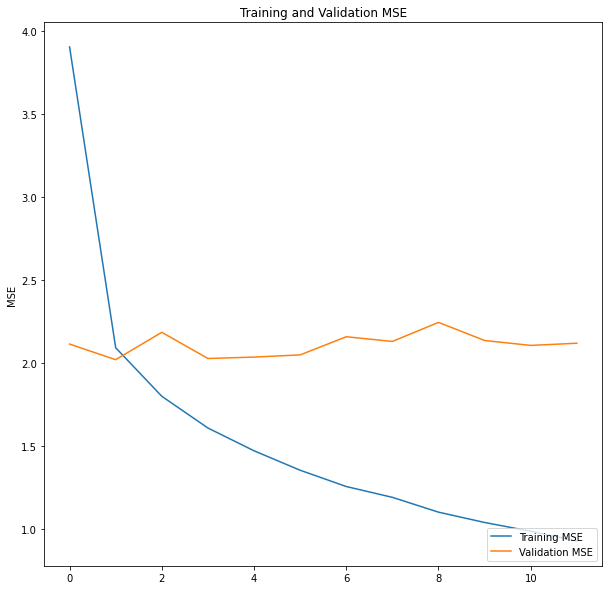

In [20]:
# Visualizing the train and the validation loss
import matplotlib.pyplot as plt

mse_bigru = history_bigru.history['mse']
val_mse_bigru = history_bigru.history['val_mse']

plt.figure(figsize=(10, 10))
plt.plot(mse_bigru, label='Training MSE')
plt.plot(val_mse_bigru, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.legend(loc='lower right')
plt.ylabel('MSE')
plt.show()

<h3>Convolutional network</h2>

In [21]:
# Fitting and retraining the model with the best params
model_conv = tuner_conv.hypermodel.build(best_hps_conv)

early_stopping=EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer=ModelCheckpoint(filepath='weights2.hdf5', save_best_only=True, verbose=1)

history_conv = model_conv.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=[checkpointer, early_stopping])

Epoch 1/100
699/699 [==============================] - ETA: 0s - loss: 2.9514 - mse: 2.9514
Epoch 1: val_loss improved from inf to 2.38007, saving model to weights2.hdf5
699/699 [==============================] - 6s 8ms/step - loss: 2.9514 - mse: 2.9514 - val_loss: 2.3801 - val_mse: 2.3801
Epoch 2/100
695/699 [============================>.] - ETA: 0s - loss: 1.9649 - mse: 1.9649
Epoch 2: val_loss improved from 2.38007 to 2.28440, saving model to weights2.hdf5
699/699 [==============================] - 5s 7ms/step - loss: 1.9641 - mse: 1.9641 - val_loss: 2.2844 - val_mse: 2.2844
Epoch 3/100
697/699 [============================>.] - ETA: 0s - loss: 1.7264 - mse: 1.7264
Epoch 3: val_loss did not improve from 2.28440
699/699 [==============================] - 5s 7ms/step - loss: 1.7256 - mse: 1.7256 - val_loss: 2.3683 - val_mse: 2.3683
Epoch 4/100
690/699 [============================>.] - ETA: 0s - loss: 1.5691 - mse: 1.5691
Epoch 4: val_loss improved from 2.28440 to 2.25244, saving mod

In [22]:
# Prediction on the test set
model_conv.load_weights('weights2.hdf5')
pred_conv = model_conv.predict(test_feat)

1865/1865 [==============================] - 3s 2ms/step


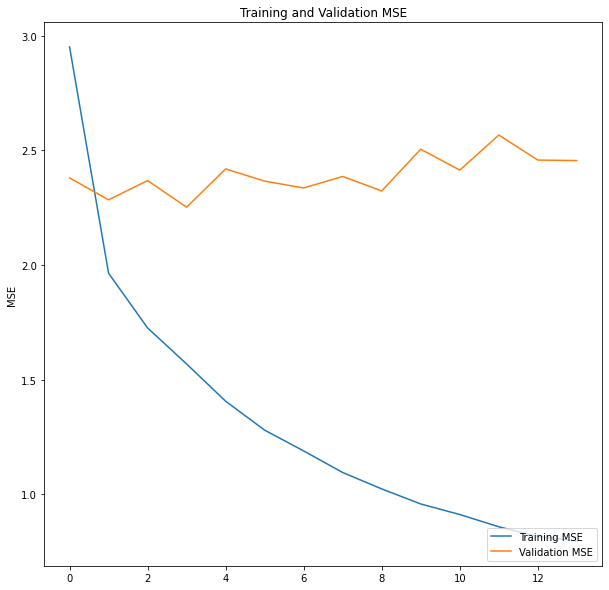

In [23]:
mse_conv = history_conv.history['mse']
val_mse_conv = history_conv.history['val_mse']

plt.figure(figsize=(10, 10))
plt.plot(mse_conv, label='Training MSE')
plt.plot(val_mse_conv, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.legend(loc='lower right')
plt.ylabel('MSE')
plt.show()

# Evaluating the models

<h3>Functions for MCD calculation and audio reconstruction<h3>

In [46]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts the spectrogram into an mgc format which can be used to evaluate the MCD score
def readmgc(x, sr):
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    return mgc

# Calculating the MCD of two given mgc-s
def calculations(x, y): 

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0

    # The calculations
    distance, path = fastdtw(x, y, dist=euclidean)

    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()
    MCD_value = _logdb_const * float(s) / float(framesTot)

    return MCD_value


# This function returns the average MCD score for the BiGRU and the Convolutional model
def compute_mcd(spec_orig, spec_bigru, spec_conv, sr):

  # Computing the mgc of the original spectrogram
  mgc_orig = readmgc(spec_orig, sr)
  print('Successfully read the original spectrogram')
  
  # Computing the mgc of the synthesized spectrograms
  mgc_bigru = readmgc(spec_bigru, sr)
  print('Successfully read the BiGRU spectrogram')

  mgc_conv =  readmgc(spec_conv, sr)
  print('Successfully read the Conv spectrogram')

  bigru_mcd = calculations(mgc_orig, mgc_bigru)
  conv_mcd = calculations(mgc_orig, mgc_conv)
  
  return bigru_mcd, conv_mcd



#Small helping function to filter out NaNs and infintes during the audio reconstruction
def makeNormal(x):
        nanIdx = np.isnan(x)
        x[nanIdx] = 0
        
        infIdx = np.isinf(x)
        x[infIdx] = 0

        return x

#Reconstructing the WAV file from the predicted mel-log spectrogram (modified Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    # we needed to change the exponential function to power function otherwise sometimes it produces faulty spectograms
    for_reconstruction = makeNormal(np.dot(np.power(spectrogram, 4), mfb.melInvMatrix))
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled


In [25]:
# Synthesize the audio from the predicted mel spectrograms

!mkdir synth_audio_bigru
!mkdir synth_audio_conv
!mkdir synth_audio_true

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


rec_bigru = createAudio(pred_bigru,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru/predicted.wav'),int(audiosr),rec_bigru)

rec_conv = createAudio(pred_conv,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_conv/predicted.wav'),int(audiosr),rec_conv)

rec_true = createAudio(test_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_true/true.wav'),int(audiosr),rec_true)


Mean Pearson correlation

In [27]:
# Pearson correlation
from scipy.stats import pearsonr

# BiGRU
corrs_1 = []
for col in range(23):
  r, p = pearsonr(test_spec[:,col], pred_bigru[:,col])
  corrs_1.append(r)
print('For the BiGRU Network, the mean Pearson correlation is:', np.mean(corrs_1))

# Conv
corrs_2 = []
for col in range(23):
  r, p = pearsonr(test_spec[:,col], pred_conv[:,col])
  corrs_2.append(r)
print('For the Convolutional Network, the mean Pearson correlation is:', np.mean(corrs_2))

For the BiGRU Network, the mean Pearson correlation is: 0.7518914675477266
For the Convolutional Network, the mean Pearson correlation is: 0.7109523786347279


RMSE

In [28]:
from sklearn.metrics import mean_squared_error as mse

print('For the BiGRU Network, the RMSE is:', mse(test_spec, pred_bigru)**0.5)
print('For the Convolutional Network, the RMSE is:', mse(test_spec, pred_conv)**0.5)

For the BiGRU Network, the RMSE is: 1.427487766369044
For the Convolutional Network, the RMSE is: 1.504625689881999


Displaying the spectrograms

In [29]:
import librosa
import pyworld

#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav


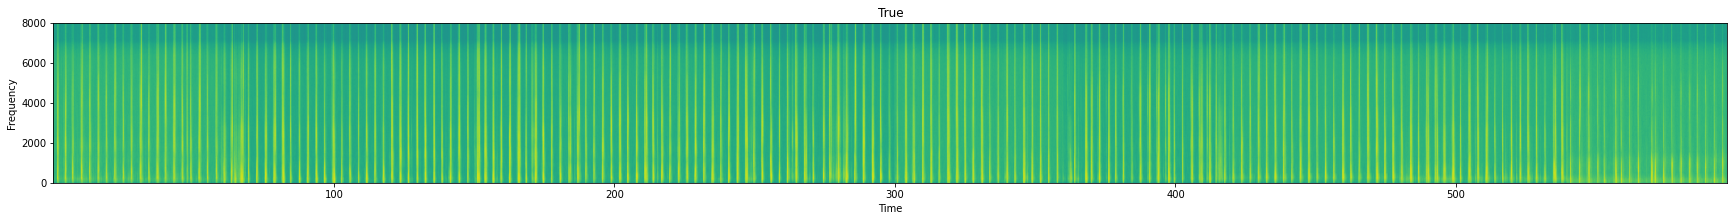

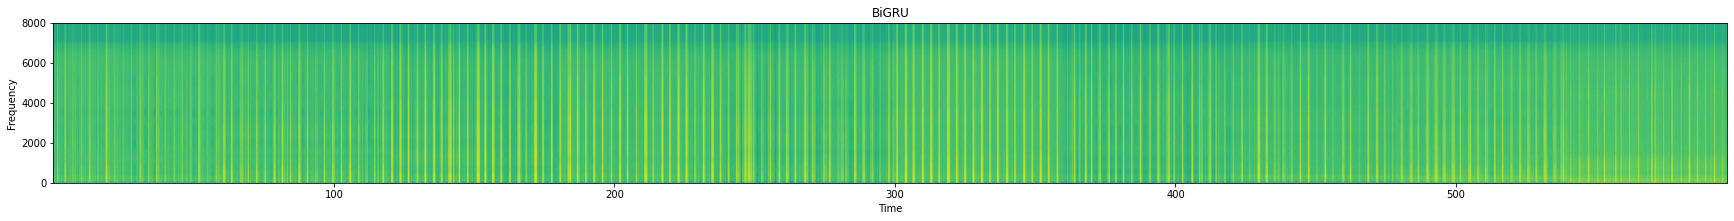

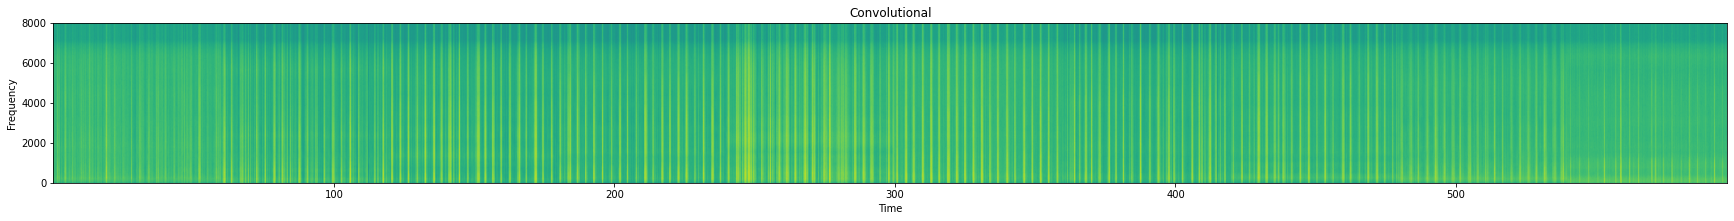

In [30]:
# Showing the spectrograms

plt.figure(figsize = (30,10))
plt.subplot(311)
plt.specgram(rec_true, Fs=16000)
plt.title('True')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(312)
plt.specgram(rec_bigru, Fs=16000)
plt.title('BiGRU')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(313)
plt.specgram(rec_conv, Fs=16000)
plt.title('Convolutional')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()


In [36]:
# Finally, let's have a look at the beginning of the reconstructed audios
from IPython.display import Audio

Audio(rec_bigru[:500000], rate=16000)

In [37]:
Audio(rec_conv[:500000], rate=16000)

Average MCD score

In [47]:
# Finally, calculating the MCD for both models
# We average over the 10 parts of the spectrograms which belong to different subjects

bigru_all = 0
conv_all = 0


for i in range(10):
  print('Epoch: ',i+1)
  bigru_mcd, conv_mcd = compute_mcd(rec_true[int(len(rec_true)*i/10):int(len(rec_true)*(i+1)/10)], 
                                    rec_bigru[int(len(rec_bigru)*i/10):int(len(rec_bigru)*(i+1)/10)], 
                                    rec_conv[int(len(rec_conv)*i/10):int(len(rec_conv)*(i+1)/10)], 
                                    16000)
  bigru_all += bigru_mcd
  conv_all += conv_mcd

print('The average MCD of the BiGRU model:', bigru_all/10)
print('The average MCD of the Conv model:', conv_all/10)

Epoch:  1
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  2
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  3
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  4
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  5
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  6
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  7
Successfully read the original spectrogram
Successfully read the BiGRU spectrogram
Successfully read the Conv spectrogram
Epoch:  8
Successfully read the original spectrogram
Successfully read the B